In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from google.colab import files

In [ ]:
uploaded = files.upload()

import zipfile
import io

zip_name = next(iter(uploaded))
with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), 'r') as zip_ref:
    zip_ref.extractall('/content/')

Saving FERPlus.zip to FERPlus.zip


In [ ]:
BATCH_SIZE = 256
EPOCHS = 50
NUM_CLASSES = 7
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BASE_PATH = '/content'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
TEST_PATH = os.path.join(BASE_PATH, 'test')

In [ ]:
EMOTION_LABELS = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

In [ ]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1))
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc(x)
        return x

In [ ]:
print(f"Using device: {DEVICE}")
print(f"Training data path: {TRAIN_PATH}")
print(f"Testing data path: {TEST_PATH}")

train_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root=TRAIN_PATH,
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root=TEST_PATH,
    transform=test_transform
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)


Using device: cuda:0
Training data path: /content/train
Testing data path: /content/test
Number of training samples: 58379
Number of testing samples: 7341


In [ ]:
def train(model, device, train_loader, optimizer):

    model.train()

    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_idx, (input, target) in enumerate(train_loader):
        input = input.to(DEVICE)
        target = target.type(torch.LongTensor).to(DEVICE)

        optimizer.zero_grad()
        output = model(input)

        loss = nn.CrossEntropyLoss()
        loss_value = loss(output, target)

        loss_value.backward()
        optimizer.step()

        train_loss += loss_value
        train_correct += torch.sum(torch.argmax(output, dim=1) == target)
        train_total += input.shape[0]

    avg_loss = train_loss.item() / len(test_loader)
    accuracy = (train_correct / train_total).item()

    return avg_loss, accuracy

In [ ]:
def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(test_loader):
            input = input.to(DEVICE)
            target = target.type(torch.LongTensor).to(DEVICE)

            output = model(input)
            predictions = torch.argmax(output, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            loss = nn.CrossEntropyLoss()
            loss_value = loss(output, target)

            test_loss += loss_value.item()
            test_correct += torch.sum(torch.argmax(output, dim=1) == target).item()
            test_total += input.shape[0]

    cm = confusion_matrix(all_targets, all_predictions)
    test_loss = test_loss / len(test_loader)
    accuracy = test_correct / test_total

    return test_loss, accuracy, cm

Epoch 1/50:
Train Loss: 12.8612 | Train Acc: 35.57%
Test Loss: 1.4027 | Test Acc: 47.73%
Epoch 2/50:
Train Loss: 9.4664 | Train Acc: 55.29%
Test Loss: 1.0786 | Test Acc: 59.37%
Epoch 3/50:
Train Loss: 8.1046 | Train Acc: 62.31%
Test Loss: 0.9512 | Test Acc: 64.95%
Epoch 4/50:
Train Loss: 7.2730 | Train Acc: 66.18%
Test Loss: 0.8340 | Test Acc: 70.06%
Epoch 5/50:
Train Loss: 6.6921 | Train Acc: 68.92%
Test Loss: 0.8029 | Test Acc: 70.39%
Epoch 6/50:
Train Loss: 6.3146 | Train Acc: 70.66%
Test Loss: 0.9146 | Test Acc: 68.70%
Epoch 7/50:
Train Loss: 5.9147 | Train Acc: 72.52%
Test Loss: 0.8895 | Test Acc: 69.08%
Epoch 8/50:
Train Loss: 5.6137 | Train Acc: 74.03%
Test Loss: 0.9168 | Test Acc: 69.58%
Epoch 9/50:
Train Loss: 5.2991 | Train Acc: 75.40%
Test Loss: 1.0055 | Test Acc: 69.99%
Epoch 10/50:
Train Loss: 5.0822 | Train Acc: 76.33%
Test Loss: 0.8732 | Test Acc: 71.83%
Epoch 11/50:
Train Loss: 4.8824 | Train Acc: 77.30%
Test Loss: 0.8935 | Test Acc: 72.54%
Epoch 12/50:
Train Loss: 4.99

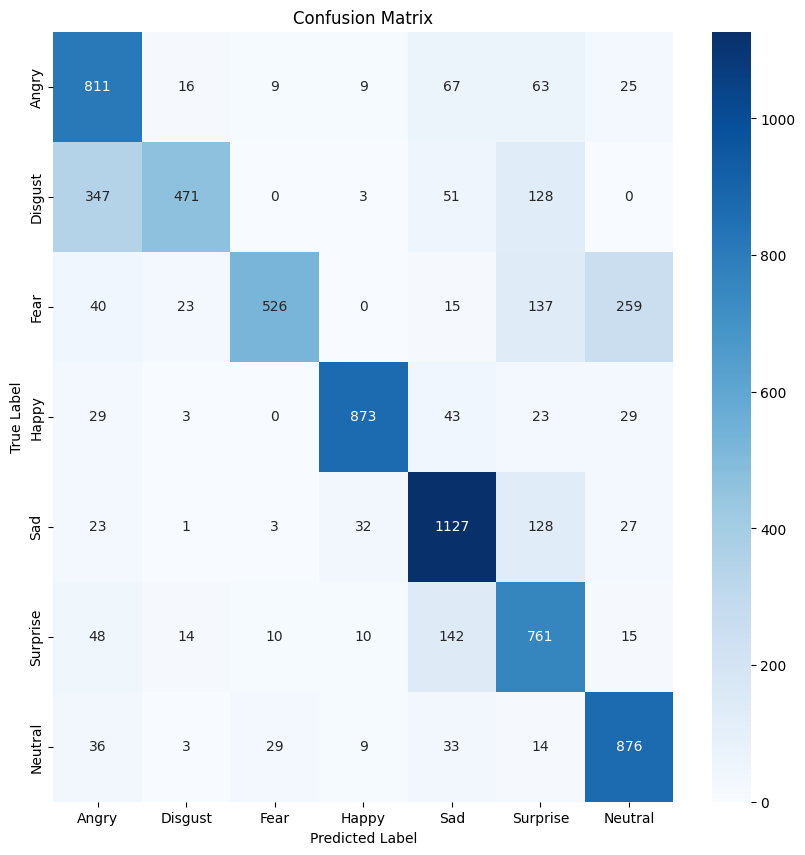

In [ ]:
model = BaselineCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

best_acc = 0
best_model_wts = None

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, DEVICE, train_loader, optimizer)
    test_loss, test_acc, cm = test(model, DEVICE, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    scheduler.step(test_acc)

    print(f'Epoch {epoch+1}/{EPOCHS}:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%')

    if test_acc > best_acc:
        best_acc = test_acc
        best_model_wts = model.state_dict()

    if epoch == 49:

      plt.figure(figsize=(10, 10))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=EMOTION_LABELS.values(),
                  yticklabels=EMOTION_LABELS.values())
      plt.xlabel('Predicted Label')
      plt.ylabel('True Label')
      plt.title('Confusion Matrix')
      plt.show()

torch.save(best_model_wts, 'best_model.pth')

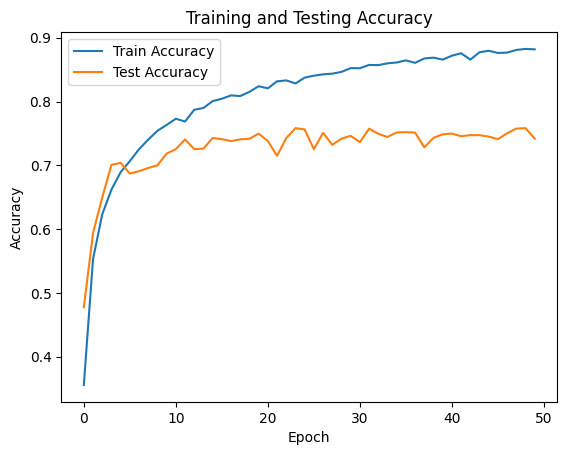

In [ ]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

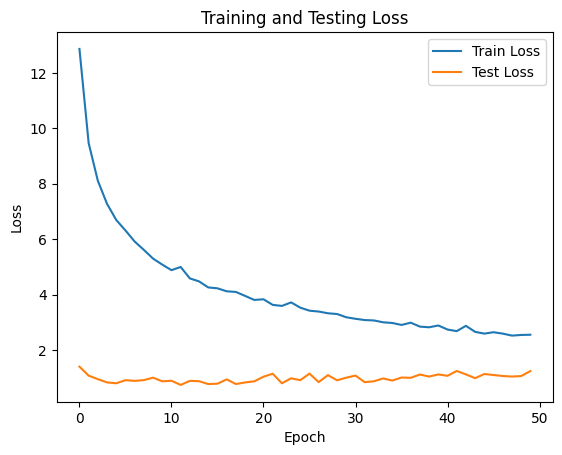

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

In [ ]:
class InferenceModel(nn.Module):
    def __init__(self, original_model):
        super(InferenceModel, self).__init__()
        self.original_model = original_model

    def forward(self, x):
        x = self.original_model(x)
        return torch.softmax(x, dim=1)

best_model = BaselineCNN().to(DEVICE)
best_model.load_state_dict(torch.load('best_model.pth'))

inference_model = InferenceModel(best_model).to(DEVICE)

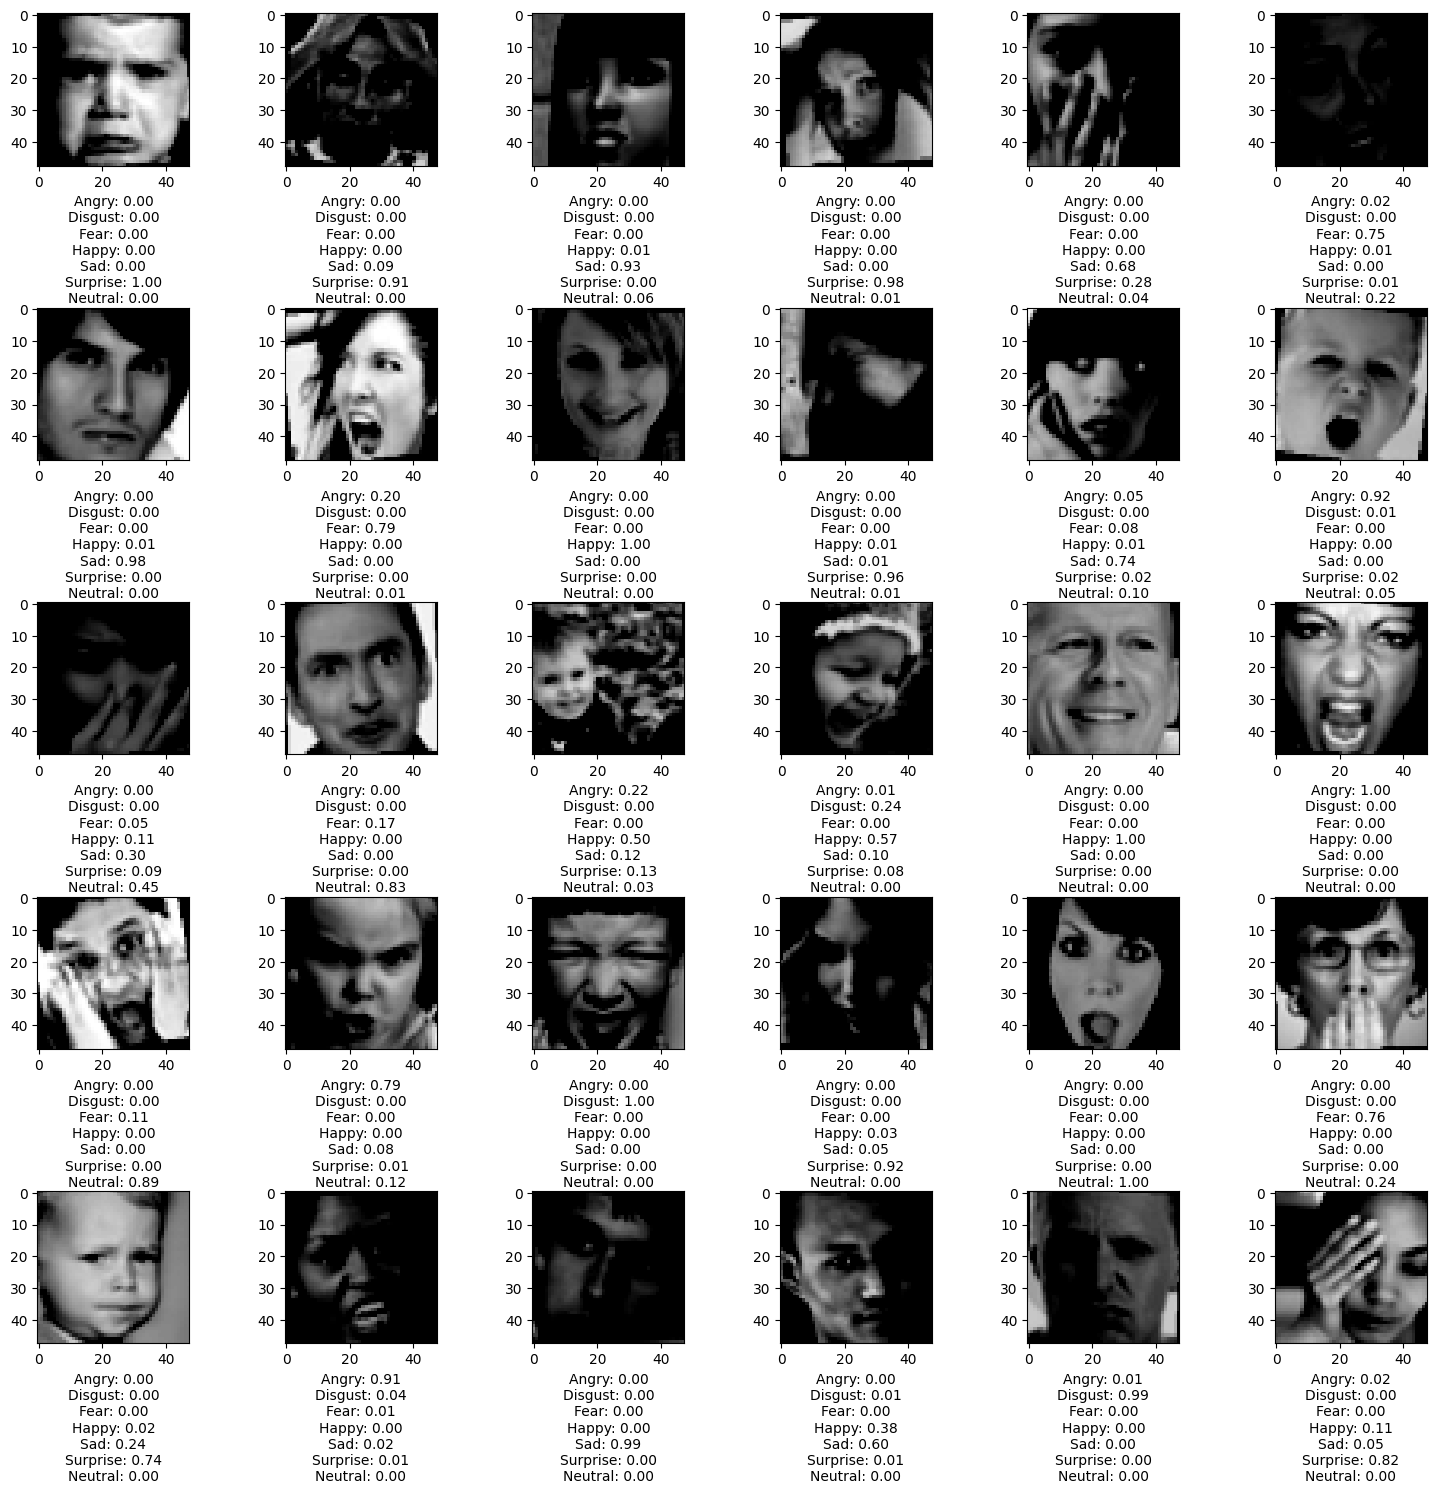

In [ ]:
sample_indices = np.random.choice(len(test_dataset),30, replace=False)
sample_images = [test_dataset[i][0] for i in sample_indices]
sample_labels = [test_dataset[i][1] for i in sample_indices]

model.eval()
with torch.no_grad():
    sample_inputs = torch.stack(sample_images).to(DEVICE)
    sample_outputs = inference_model(sample_inputs)
    sample_probs = sample_outputs.cpu().numpy()

fig, axes = plt.subplots(5, 6, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i].permute(1, 2, 0))
    probs_str = ""
    for j, emotion in EMOTION_LABELS.items():
        probs_str += f"{emotion}: {sample_probs[i][j]:.2f}\n"
    ax.set_xlabel(probs_str)
plt.tight_layout()
plt.show()

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.1 M

In [ ]:
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import random

def visualize_gradcam_batch(model, dataset, device, num_images=10,
                             target_layer=None, use_rgb=False,
                             image_size=48, num_input_channels=1):
    model.eval()

    if target_layer is None:
        target_layer = model.conv3[-3]

    cam = GradCAM(model=model, target_layers=[target_layer])

    indices = random.sample(range(len(dataset)), num_images)

    cols = 4
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)
        output = model(input_tensor)
        predicted_class = output.argmax(dim=1).item()

        # Generate Grad-CAM
        targets = [ClassifierOutputTarget(predicted_class)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

        input_image = image.cpu().numpy()
        input_image = np.transpose(input_image, (1, 2, 0))  # [C,H,W] -> [H,W,C]
        input_image = (input_image * 0.5) + 0.5
        input_image = np.clip(input_image, 0, 1)

        if not use_rgb and input_image.shape[2] == 1:
          input_image = np.repeat(input_image, 3, axis=2)

        visualization = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)
        ax = axes[i]
        ax.imshow(visualization)
        ax.axis('off')
        ax.set_title(f"Pred: {EMOTION_LABELS[predicted_class]}\nTrue: {EMOTION_LABELS[label]}")

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

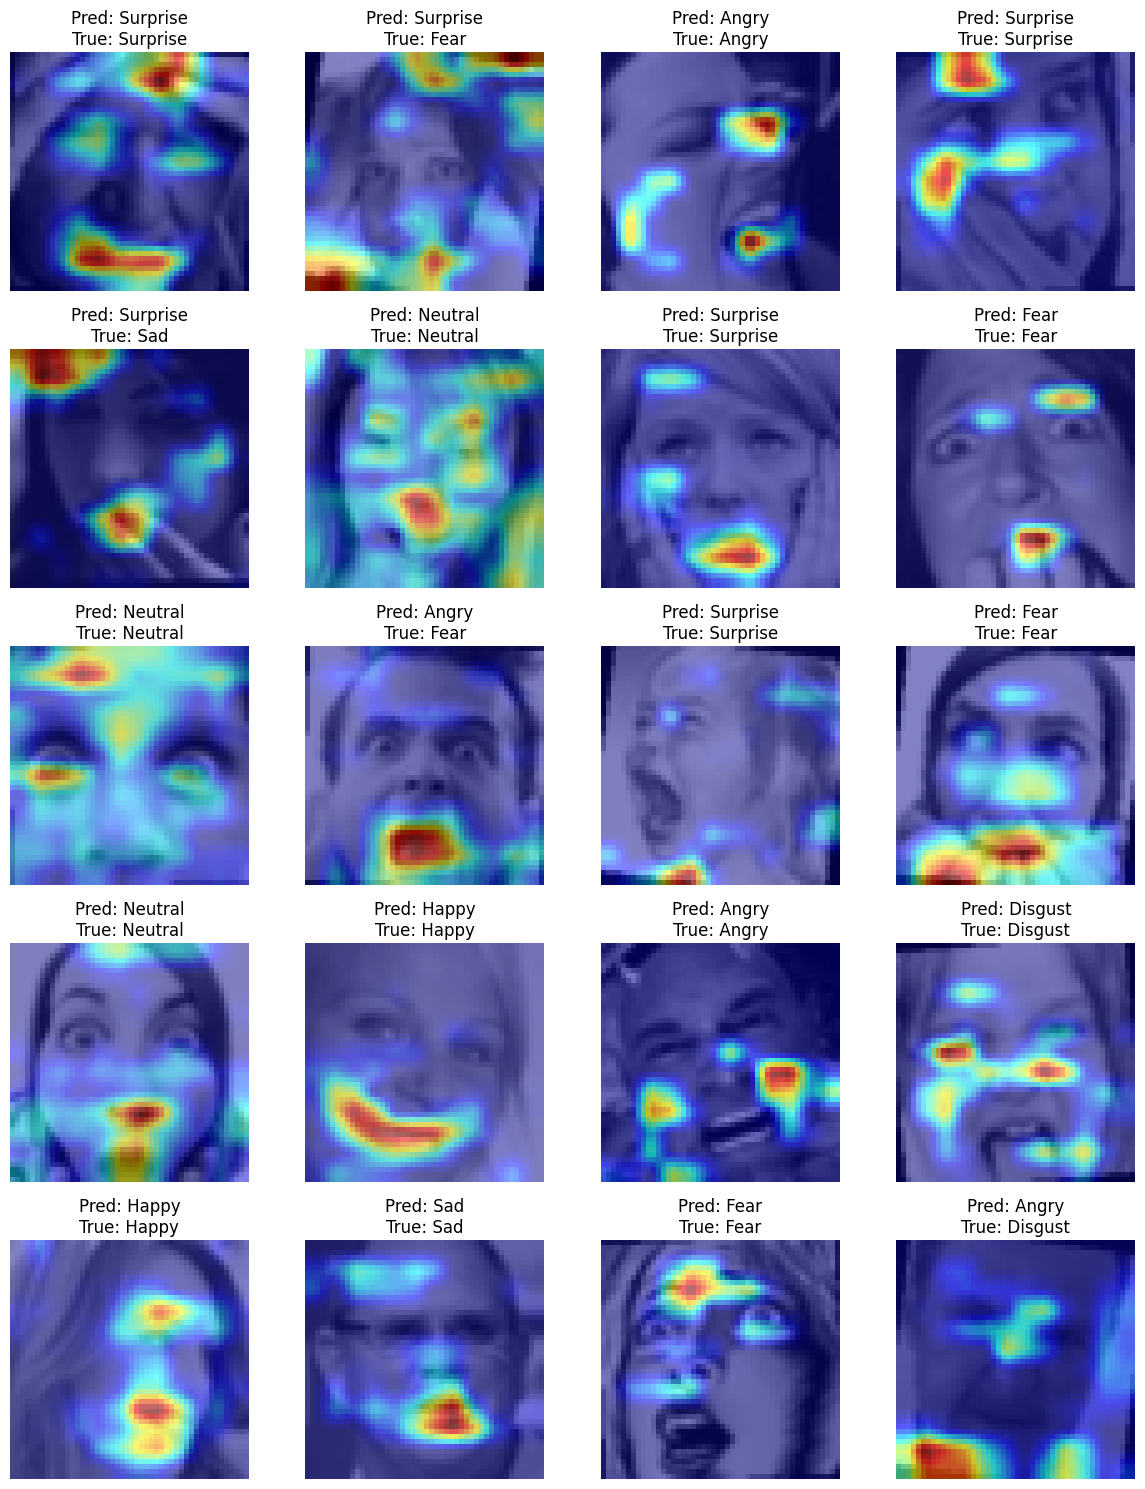

In [ ]:
visualize_gradcam_batch(
    model,
    test_dataset,
    device=DEVICE,
    num_images=20,
    target_layer=None,
    use_rgb=False
)